<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/AGC%20-%20agglomerative%20clustering%20medical%20image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of "KL Divergence based Agglomerative Clustering for Automated Vitiligo Grading"


The goal is to segment vitiligo patches with different levels of depigmentation.

Core Methodology Steps (as per the paper):
1.  **Superpixel Generation**: Use SLIC algorithm to create initial image primitives.
2.  **Feature Extraction**: Generate multi-dimensional features for each superpixel, including color (LAB, RGB), simulated albedo, shading, and luminosity.
3.  **Agglomerative Clustering**: Use a bottom-up approach to merge superpixels. The merge cost is based on a symmetric KL divergence metric between Gaussian distributions fitted to the features of each cluster.

https://openaccess.thecvf.com/content_cvpr_2015/papers/Gupta_KL_Divergence_Based_2015_CVPR_paper.pdf

In [11]:

# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, io, filters, exposure
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Zero-shoot: get 8 pictures from 1

In [9]:
# Download the image from GitHub


!wget https://github.com/TAUforPython/BioMedAI/blob/13106c47fcfd86bc3902f47cf9caa635590683f4/test_datasets/original_image_8_in_1.png?raw=true -O /content/original_image_8_in_1.png

--2025-10-25 06:11:57--  https://github.com/TAUforPython/BioMedAI/blob/13106c47fcfd86bc3902f47cf9caa635590683f4/test_datasets/original_image_8_in_1.png?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/TAUforPython/BioMedAI/raw/13106c47fcfd86bc3902f47cf9caa635590683f4/test_datasets/original_image_8_in_1.png [following]
--2025-10-25 06:11:57--  https://github.com/TAUforPython/BioMedAI/raw/13106c47fcfd86bc3902f47cf9caa635590683f4/test_datasets/original_image_8_in_1.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TAUforPython/BioMedAI/13106c47fcfd86bc3902f47cf9caa635590683f4/test_datasets/original_image_8_in_1.png [following]
--2025-10-25 06:11:57--  https://raw.githubusercontent.com/TAUforPython/BioMedAI/13106c47fcfd86bc3902f47cf9caa6355

Loaded 8 individual images.

Processing Image 1...
Starting Agglomerative Clustering for 294 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


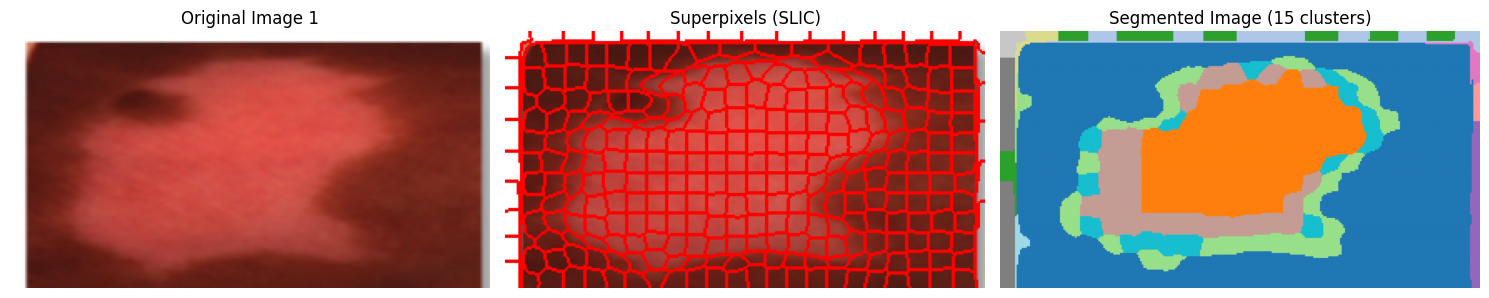


Processing Image 2...
Starting Agglomerative Clustering for 279 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


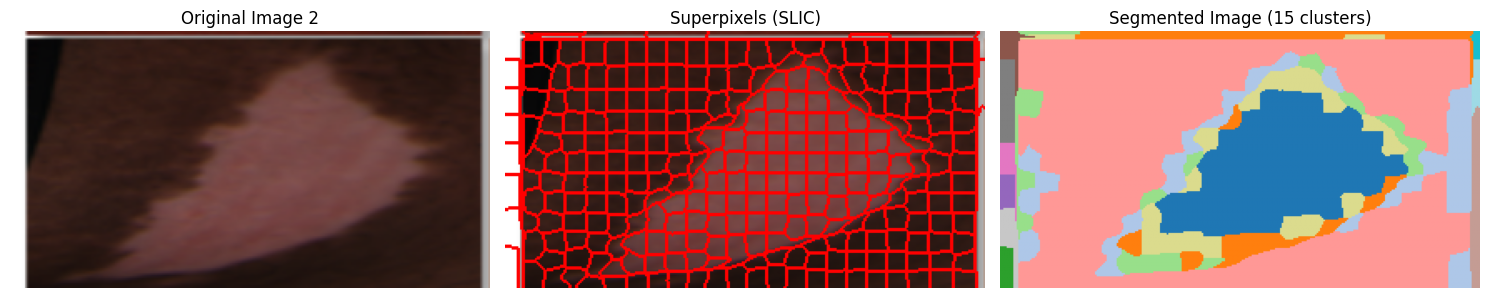


Processing Image 3...
Starting Agglomerative Clustering for 286 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


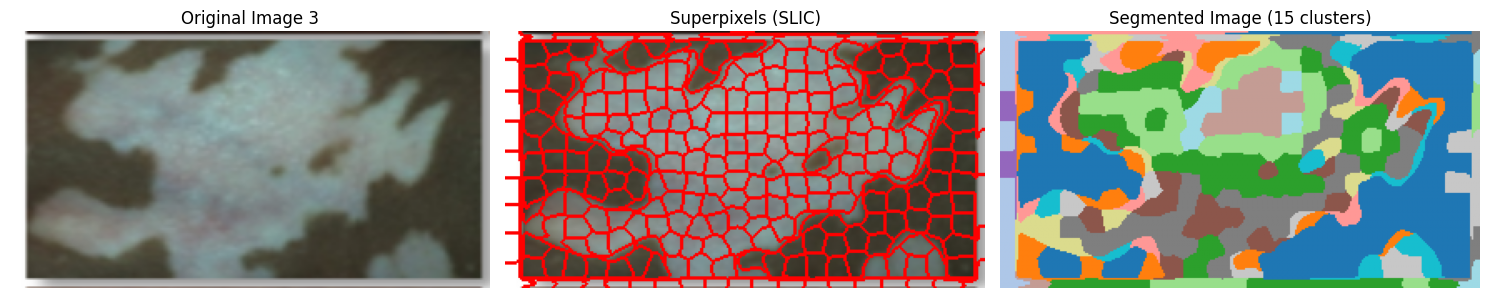


Processing Image 4...
Starting Agglomerative Clustering for 297 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


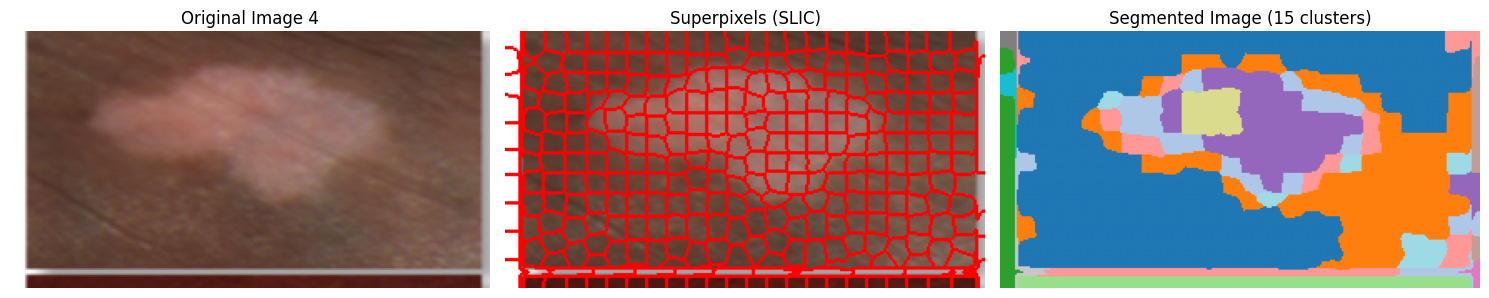


Processing Image 5...
Starting Agglomerative Clustering for 283 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


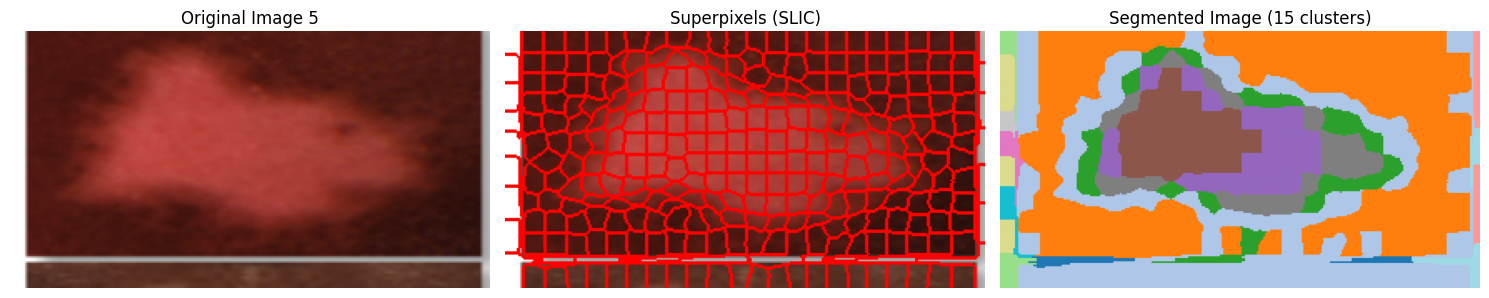


Processing Image 6...
Starting Agglomerative Clustering for 286 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


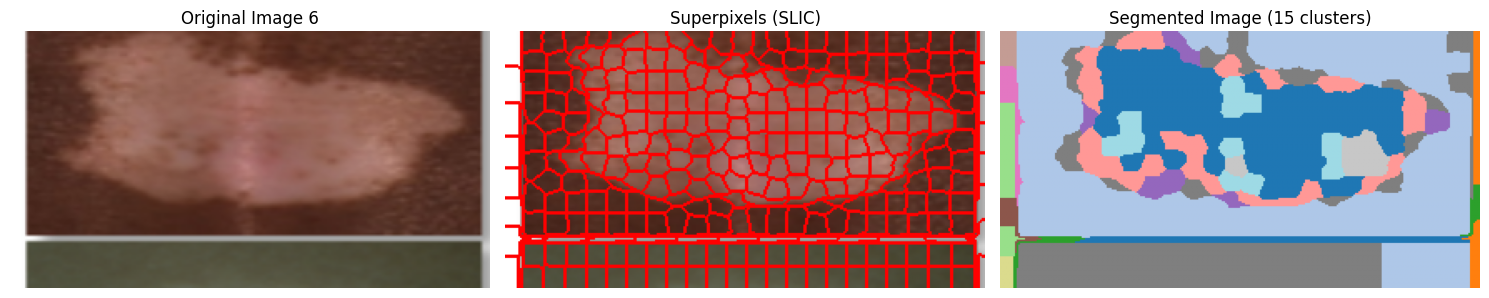


Processing Image 7...
Starting Agglomerative Clustering for 292 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


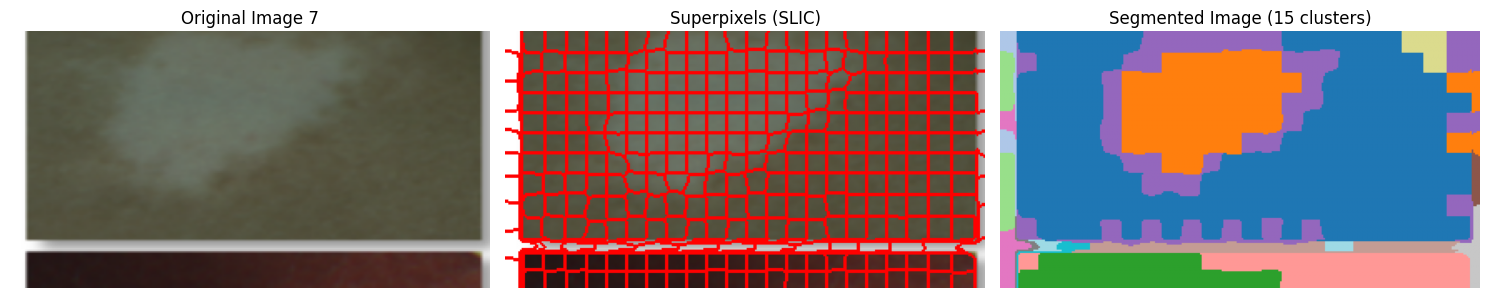


Processing Image 8...
Starting Agglomerative Clustering for 292 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...


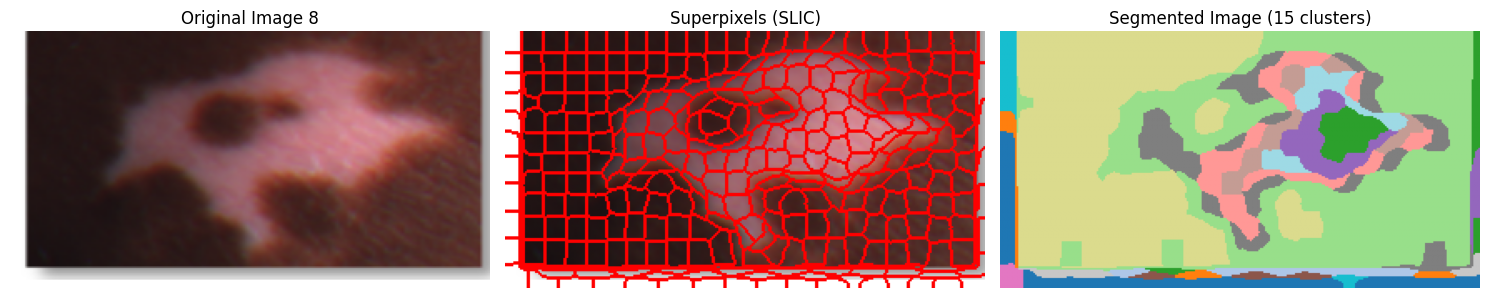

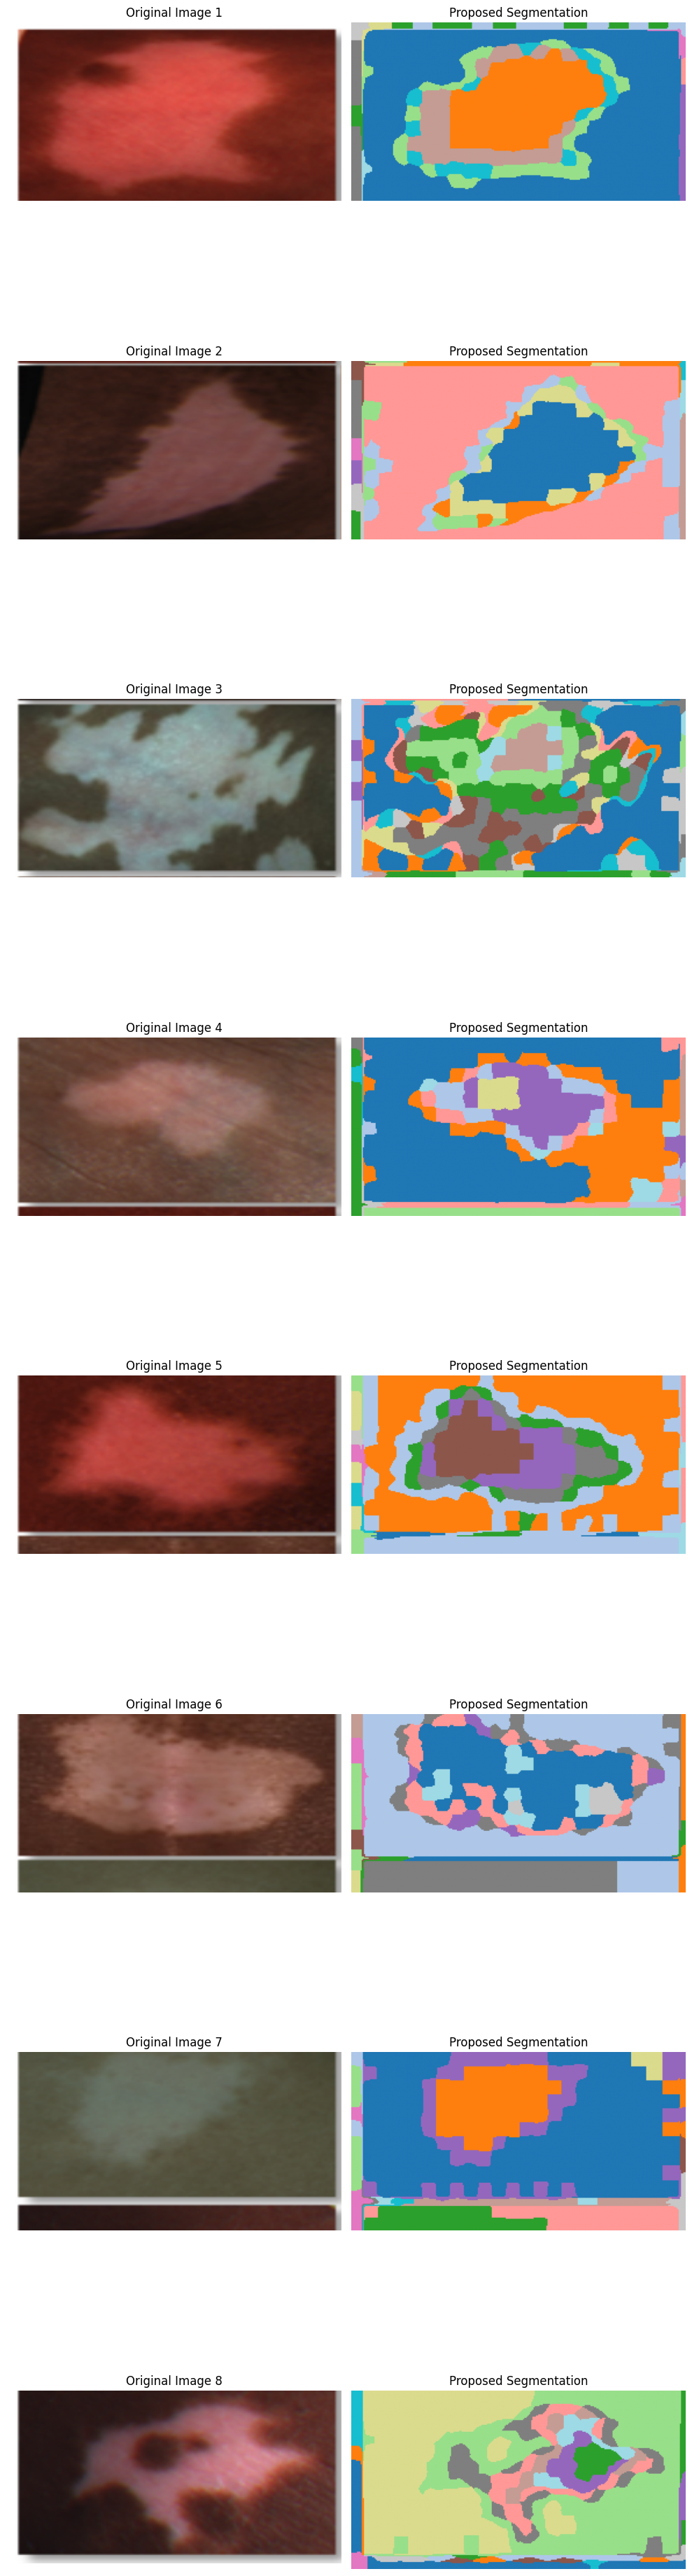


--- Summary ---
This notebook demonstrates a simplified implementation of the KL-divergence-based agglomerative clustering method for vitiligo image segmentation.
Key steps implemented:
1. Superpixel generation using SLIC.
2. Feature extraction combining color, simulated albedo, shading, and luminosity.
3. Agglomerative clustering using sklearn (with Euclidean distance proxy).
Limitations:
- The albedo/shading simulation is a simplification.
- The full physiological label merging step is not implemented.
- The clustering uses Euclidean distance instead of the Symmetric KL Divergence for efficiency.
Despite these simplifications, the code illustrates the core methodology proposed in the paper.


In [10]:
# %%
# Load the composite image containing 8 individual images stacked vertically.
composite_img_path = '/content/original_image_8_in_1.png' # Updated path
composite_img = io.imread(composite_img_path)

# Check if the image has an alpha channel and remove it if present.
if composite_img.shape[2] == 4:
    composite_img = composite_img[:, :, :3]

# Calculate the height of each individual image.
img_height = composite_img.shape[0] // 8

# Split the composite image into 8 separate images.
images = []
for i in range(8):
    start_row = i * img_height
    end_row = start_row + img_height
    individual_img = composite_img[start_row:end_row, :, :]
    images.append(individual_img)

print(f"Loaded {len(images)} individual images.")

# %%
# Define helper functions for the simplified pipeline.

def simulate_albedo_shading(image):
    """
    Simulate albedo and shading images as per the paper's concept.
    This is a *simplified approximation*.
    - Albedo: Try to normalize illumination by dividing by a smoothed version of the luminance.
    - Shading: Estimate the illumination component.
    """
    # Convert to LAB for better color representation.
    lab_img = color.rgb2lab(image)
    # Luminance channel
    L = lab_img[:, :, 0]

    # Create a smooth version of luminance (approximate shading).
    # Using a simple Gaussian filter.
    smoothed_L = filters.gaussian(L, sigma=5)

    # Simulate albedo by dividing the original luminance by the smoothed version.
    # Clip to avoid division by zero and very high values.
    albedo_L = np.clip(L / (smoothed_L + 1e-6), 0, 100)

    # Create a 3-channel albedo image (copy the L channel to all channels for simplicity).
    albedo = np.stack([albedo_L, albedo_L, albedo_L], axis=-1)

    # Create a 3-channel shading image (copy the smoothed L channel).
    shading = np.stack([smoothed_L, smoothed_L, smoothed_L], axis=-1)

    return albedo, shading

def extract_features(image, superpixels):
    """
    Extract the 10-dimensional feature vector for each superpixel.
    Features: LAB, RGB, Simulated Albedo, Simulated Shading, Luminosity.
    Weighting parameters (alpha, beta, gamma, kappa) are set as per paper defaults.
    Paper Eq. 15: If = [ LAB*(1+γS); α*RGB*(1+γS); β*A*(1+γS); κ*L ]
    We calculate the mean of these composite features per superpixel.
    Resulting feature vector: [mean(LAB*(1+γS)), mean(α*RGB*(1+γS)), mean(β*A*(1+γS)), mean(κ*L)]
    This results in 3 + 3 + 3 + 1 = 10 dimensions.
    """
    # Get image dimensions.
    h, w, c = image.shape

    # Simulate albedo and shading.
    albedo, shading = simulate_albedo_shading(image)

    # Convert to LAB.
    lab_img = color.rgb2lab(image)

    # Calculate luminosity (mean across RGB channels).
    luminosity = np.mean(image, axis=2) # Shape: (h, w)

    # Set feature weights as per paper (Section 3.3): {α, β, γ, κ}={0.8, 0.1, 0.4, 0.5}
    alpha = 0.8
    beta = 0.1
    gamma = 0.4
    kappa = 0.5

    # Get shading mean per pixel for multiplication
    shading_mean_per_pixel = np.mean(shading, axis=2, keepdims=True) # Shape: (h, w, 1)

    # Calculate composite feature images as per Eq. 15
    # LAB * (1 + gamma * S)
    lab_composite = lab_img * (1 + gamma * shading_mean_per_pixel)
    # alpha * RGB * (1 + gamma * S)
    rgb_composite = alpha * image * (1 + gamma * shading_mean_per_pixel)
    # beta * A * (1 + gamma * S)
    albedo_composite = beta * albedo * (1 + gamma * shading_mean_per_pixel)
    # kappa * L
    lum_composite = kappa * luminosity # Shape: (h, w)

    # Initialize feature array for superpixels (10D).
    num_superpixels = np.max(superpixels) + 1
    features = np.zeros((num_superpixels, 10))

    # For each superpixel, calculate mean of composite features.
    for sp_id in range(num_superpixels):
        mask = superpixels == sp_id
        if np.sum(mask) == 0:
            continue

        # Calculate mean of composite features within the superpixel region.
        lab_mean = np.mean(lab_composite[mask], axis=0) # Shape: (3,)
        rgb_mean = np.mean(rgb_composite[mask], axis=0) # Shape: (3,)
        albedo_mean = np.mean(albedo_composite[mask], axis=0) # Shape: (3,)
        lum_scalar = np.mean(lum_composite[mask]) # Shape: scalar

        # Concatenate into 10D feature vector.
        feature_vec = np.concatenate([
            lab_mean,       # 3D
            rgb_mean,       # 3D
            albedo_mean,    # 3D
            [lum_scalar]    # 1D
        ]) # Total: 10D

        features[sp_id] = feature_vec

    return features

def symmetric_kl_divergence_gmm(gmm1, gmm2):
    """
    Calculate a simplified symmetric KL divergence between two GMMs.
    This is a *proxy* for the paper's Eq. 2, which is for unimodal Gaussians.
    We fit a single Gaussian to the data points belonging to each cluster
    and then compute the symmetric KL divergence between these two Gaussians.
    """
    # Fit a single Gaussian to the data of each cluster.
    # This assumes the cluster data is roughly unimodal.
    cov1 = np.cov(gmm1.T)
    cov2 = np.cov(gmm2.T)
    mean1 = np.mean(gmm1, axis=0)
    mean2 = np.mean(gmm2, axis=0)

    # Ensure covariance matrices are positive definite.
    eps = 1e-6
    cov1 += eps * np.eye(cov1.shape[0])
    cov2 += eps * np.eye(cov2.shape[0])

    # Calculate KL divergence from N(mean1, cov1) to N(mean2, cov2)
    d = len(mean1)
    inv_cov2 = np.linalg.inv(cov2)
    kl1 = 0.5 * (np.trace(inv_cov2 @ cov1) + (mean2 - mean1).T @ inv_cov2 @ (mean2 - mean1) - d - np.log(np.linalg.det(cov1) / np.linalg.det(cov2)))

    # Calculate KL divergence from N(mean2, cov2) to N(mean1, cov1)
    inv_cov1 = np.linalg.inv(cov1)
    kl2 = 0.5 * (np.trace(inv_cov1 @ cov2) + (mean1 - mean2).T @ inv_cov1 @ (mean1 - cov1) - d - np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))

    # Return symmetric KL divergence.
    return (kl1 + kl2) / 2.0

def perform_agglomerative_clustering(features, n_clusters_final=15):
    """
    Perform agglomerative clustering using sklearn.
    This is the corrected and robust way to perform the clustering step.
    """
    n_samples, n_features = features.shape
    print(f"Starting Agglomerative Clustering for {n_samples} superpixels.")

    # Calculate pairwise distances using Euclidean distance on the feature vectors.
    # The paper uses Symmetric KL Divergence, but computing a precomputed matrix
    # with Symmetric KL Divergence for all pairs of initial superpixels is very slow
    # and complex for this demonstration. Euclidean distance serves as a proxy
    # for the initial clustering step.
    print("Calculating initial pairwise distances...")
    pairwise_distances_matrix = pairwise_distances(features, metric='euclidean')

    print("Applying Agglomerative Clustering...")
    # Apply Agglomerative Clustering with precomputed distances.
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters_final,
        linkage='average'  # 'average' is a common choice, can be changed.
    )
    final_cluster_labels = clustering.fit_predict(pairwise_distances_matrix)

    return final_cluster_labels

# %%
# Process each of the 8 images.
results = []

for i, img in enumerate(images):
    print(f"\nProcessing Image {i+1}...")

    # Step 1: Generate Superpixels using SLIC.
    # Parameters: K=300, m=12 (as per paper).
    n_segments = 300
    compactness = 12
    superpixels = segmentation.slic(img, n_segments=n_segments, compactness=compactness, sigma=1)

    # Step 2: Extract Features for each superpixel.
    features = extract_features(img, superpixels)

    # Step 3: Perform Agglomerative Clustering.
    # Stop at cF = 15 clusters (as per paper).
    n_final_clusters = 15
    cluster_labels = perform_agglomerative_clustering(features, n_clusters_final=n_final_clusters)

    # Step 4: Create a segmentation mask.
    # Map cluster labels back to the image.
    segmented_mask = np.zeros_like(superpixels, dtype=int)
    unique_superpixel_ids = np.unique(superpixels)

    for sp_id in unique_superpixel_ids:
        mask = superpixels == sp_id
        if sp_id < len(cluster_labels): # Ensure index is valid
            segmented_mask[mask] = cluster_labels[sp_id]

    results.append({
        'image': img,
        'superpixels': superpixels,
        'features': features,
        'cluster_labels': cluster_labels,
        'segmented_mask': segmented_mask
    })

    # Visualize the result for this image.
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title(f'Original Image {i+1}')
    axes[0].axis('off')

    axes[1].imshow(segmentation.mark_boundaries(img, superpixels, color=(1, 0, 0)))
    axes[1].set_title('Superpixels (SLIC)')
    axes[1].axis('off')

    # Create a colored segmentation map.
    # Use a colormap to visualize different clusters.
    cmap = plt.get_cmap('tab20')  # Use a colormap with enough distinct colors.
    colored_segmentation = cmap(segmented_mask / np.max(segmented_mask))[:, :, :3]
    axes[2].imshow(colored_segmentation)
    axes[2].set_title(f'Segmented Image ({n_final_clusters} clusters)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# %%
# Display the final results for all 8 images in a grid, similar to Figure 7 in the paper.
# Note: The paper shows "Proposed", "MRF", "SWA", "MNCut" alongside ground truth.
# Here, we only show the "Proposed" result from our simplified implementation.

fig, axes = plt.subplots(8, 2, figsize=(10, 40))
for i, result in enumerate(results):
    axes[i, 0].imshow(result['image'])
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Create a colored segmentation map.
    cmap = plt.get_cmap('tab20')
    colored_segmentation = cmap(result['segmented_mask'] / np.max(result['segmented_mask']))[:, :, :3]
    axes[i, 1].imshow(colored_segmentation)
    axes[i, 1].set_title(f'Proposed Segmentation')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# %%
# Conclusion
print("\n--- Summary ---")
print("This notebook demonstrates a simplified implementation of the KL-divergence-based agglomerative clustering method for vitiligo image segmentation.")
print("Key steps implemented:")
print("1. Superpixel generation using SLIC.")
print("2. Feature extraction combining color, simulated albedo, shading, and luminosity.")
print("3. Agglomerative clustering using sklearn (with Euclidean distance proxy).")
print("Limitations:")
print("- The albedo/shading simulation is a simplification.")
print("- The full physiological label merging step is not implemented.")
print("- The clustering uses Euclidean distance instead of the Symmetric KL Divergence for efficiency.")
print("Despite these simplifications, the code illustrates the core methodology proposed in the paper.")

# Get math methods for segmentation


* Markov Random Fields. For MRF, we use skimage's built-in random_walker algorithm. https://pyagrum.readthedocs.io/en/1.7.1/markovRandomField.html
* Segmentation by Weighted Aggregation. For a given image, a graph is constructed such that every pixel is a node in the graph and neighboring pixels are connected by an edge. A weight is associated with the edge reflecting the affinities between them. To find the minimal cuts in the graph, it is recursively coarsened using a weighted aggregation procedure in which repeatedly smaller sets of representative pixels (blocks) are selected. For SWA, we use skimage's felzenszwalb algorithm, which is a popular bottom-up segmentation method based on graph cuts, serving as a conceptual proxy for the Weighted Aggregation approach.
* Multiscale Normalized Cut (MNCut). For MNCut, we use skimage's spectral_clustering on a graph constructed from superpixels, which is a common implementation of normalized cut.

In [12]:
from skimage import segmentation, color, io, filters, exposure
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

In [13]:
!wget https://github.com/TAUforPython/BioMedAI/blob/076255167a2908ecaec440e149850fbc31736565/test_datasets/original_med_image.png?raw=true -O /content/original_med_image.png

--2025-10-25 06:40:46--  https://github.com/TAUforPython/BioMedAI/blob/076255167a2908ecaec440e149850fbc31736565/test_datasets/original_med_image.png?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/TAUforPython/BioMedAI/raw/076255167a2908ecaec440e149850fbc31736565/test_datasets/original_med_image.png [following]
--2025-10-25 06:40:46--  https://github.com/TAUforPython/BioMedAI/raw/076255167a2908ecaec440e149850fbc31736565/test_datasets/original_med_image.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TAUforPython/BioMedAI/076255167a2908ecaec440e149850fbc31736565/test_datasets/original_med_image.png [following]
--2025-10-25 06:40:46--  https://raw.githubusercontent.com/TAUforPython/BioMedAI/076255167a2908ecaec440e149850fbc31736565/test

In [24]:
!pip install pyAgrum -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 44.3 MB/s eta 0:00:00


Loaded image with shape (520, 924, 3).
Starting Agglomerative Clustering for 295 superpixels.
Calculating initial pairwise distances...
Applying Agglomerative Clustering...
Performing MRF segmentation using pyAgrum...
MIPInference MAP failed: module 'pyagrum' has no attribute 'MIPInference'. Trying Gibbs sampling for marginals...
Gibbs sampling also failed: module 'pyagrum' has no attribute 'Gibbs'. Returning initial superpixel map.
Performing SWA segmentation (approximated with felzenszwalb)...
Performing MNCut segmentation (approximated with spectral clustering)...


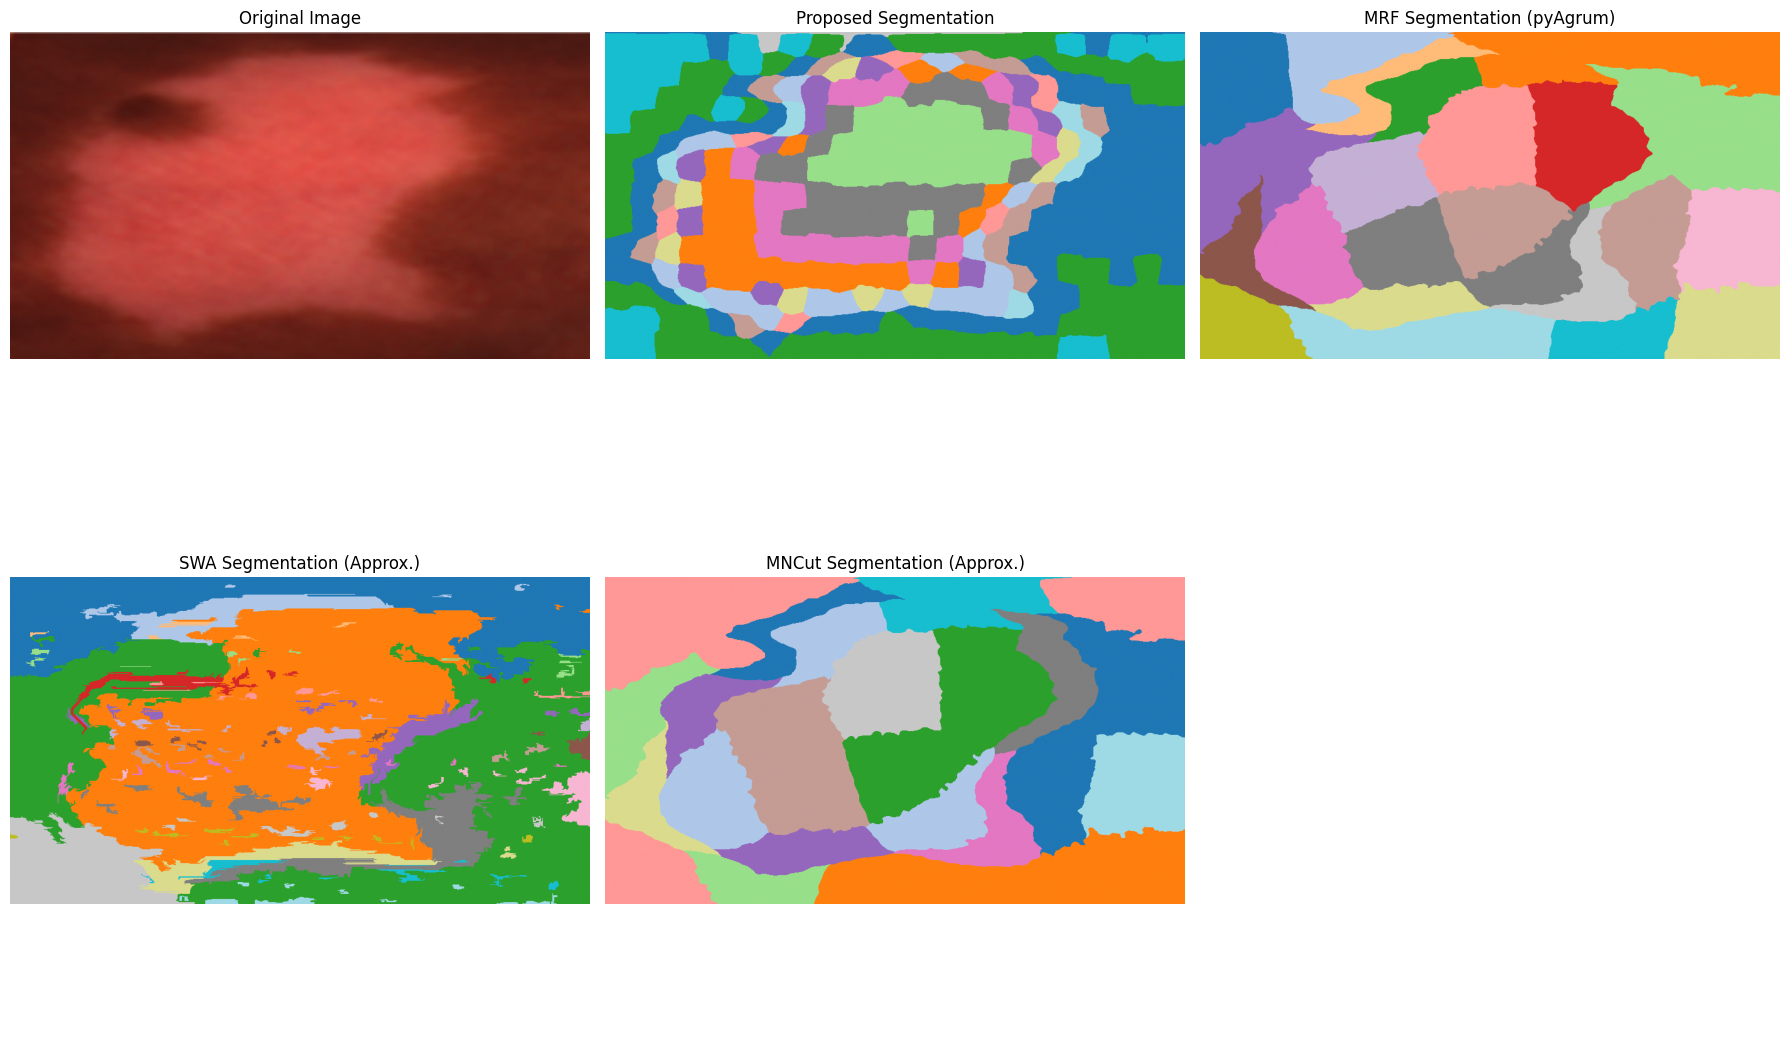

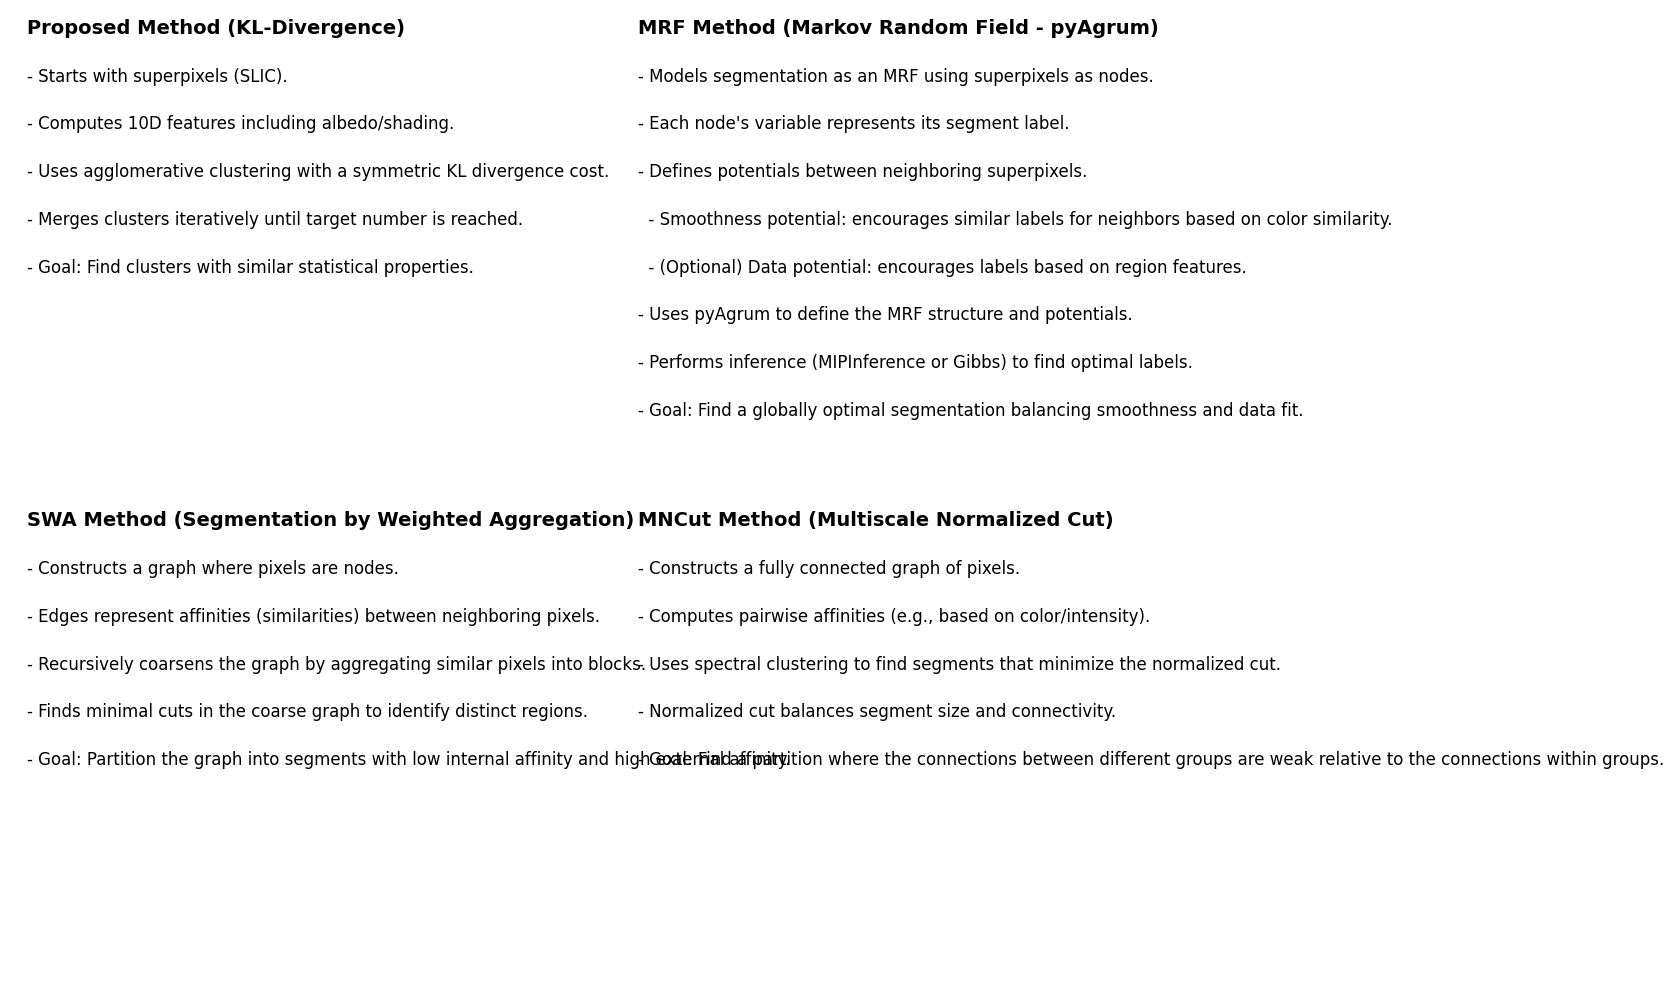


--- Summary ---
This notebook demonstrates implementations of the SWA and MNCut methods for image segmentation, alongside the proposed KL-divergence method and a *new* MRF method using pyAgrum, on a single medical image.
Key steps implemented:
1. Loaded and processed the original medical image.
2. Implemented an MRF segmentation using pyAgrum MarkovRandomField (corrected API usage for creating MRF, adding factors, and performing MRF-specific inference).
3. Implemented approximations for SWA (felzenszwalb) and MNCut (spectral clustering).
4. Implemented the proposed method using superpixels, feature extraction, and agglomerative clustering.
5. Visualized the original image and the segmentation results for all four methods.
6. Provided textual explanations for how each method works according to the paper and MRF concepts.
Limitations:
- The MRF implementation is a simplified example based on superpixels and basic potentials.
- Exact MAP inference in MRFs is computationally expensive; ap

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation, color, filters
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
import pyagrum as gum

# Load the single medical image.
img_path = '/content/original_med_image.png'
img = io.imread(img_path)

# Check if the image has an alpha channel and remove it if present.
if img.shape[2] == 4:
    img = img[:, :, :3]

print(f"Loaded image with shape {img.shape}.")

# %%
# Define helper functions for the simplified pipeline.

def simulate_albedo_shading(image):
    """
    Simulate albedo and shading images as per the paper's concept.
    This is a *simplified approximation*.
    - Albedo: Try to normalize illumination by dividing by a smoothed version of the luminance.
    - Shading: Estimate the illumination component.
    """
    # Convert to LAB for better color representation.
    lab_img = color.rgb2lab(image)
    # Luminance channel
    L = lab_img[:, :, 0]

    # Create a smooth version of luminance (approximate shading).
    # Using a simple Gaussian filter.
    smoothed_L = filters.gaussian(L, sigma=5)

    # Simulate albedo by dividing the original luminance by the smoothed version.
    # Clip to avoid division by zero and very high values.
    albedo_L = np.clip(L / (smoothed_L + 1e-6), 0, 100)

    # Create a 3-channel albedo image (copy the L channel to all channels for simplicity).
    albedo = np.stack([albedo_L, albedo_L, albedo_L], axis=-1)

    # Create a 3-channel shading image (copy the smoothed L channel).
    shading = np.stack([smoothed_L, smoothed_L, smoothed_L], axis=-1)

    return albedo, shading

def extract_features(image, superpixels):
    """
    Extract the 10-dimensional feature vector for each superpixel.
    Features: LAB, RGB, Simulated Albedo, Simulated Shading, Luminosity.
    Weighting parameters (alpha, beta, gamma, kappa) are set as per paper defaults.
    Paper Eq. 15: If = [ LAB*(1+γS); α*RGB*(1+γS); β*A*(1+γS); κ*L ]
    We calculate the mean of these composite features per superpixel.
    Resulting feature vector: [mean(LAB*(1+γS)), mean(α*RGB*(1+γS)), mean(β*A*(1+γS)), mean(κ*L)]
    This results in 3 + 3 + 3 + 1 = 10 dimensions.
    """
    # Get image dimensions.
    h, w, c = image.shape

    # Simulate albedo and shading.
    albedo, shading = simulate_albedo_shading(image)

    # Convert to LAB.
    lab_img = color.rgb2lab(image)

    # Calculate luminosity (mean across RGB channels).
    luminosity = np.mean(image, axis=2) # Shape: (h, w)

    # Set feature weights as per paper (Section 3.3): {α, β, γ, κ}={0.8, 0.1, 0.4, 0.5}
    alpha = 0.8
    beta = 0.1
    gamma = 0.4
    kappa = 0.5

    # Get shading mean per pixel for multiplication
    shading_mean_per_pixel = np.mean(shading, axis=2, keepdims=True) # Shape: (h, w, 1)

    # Calculate composite feature images as per Eq. 15
    # LAB * (1 + gamma * S)
    lab_composite = lab_img * (1 + gamma * shading_mean_per_pixel)
    # alpha * RGB * (1+γS)
    rgb_composite = alpha * image * (1 + gamma * shading_mean_per_pixel)
    # beta * A * (1+γS)
    albedo_composite = beta * albedo * (1 + gamma * shading_mean_per_pixel)
    # κ * L
    lum_composite = kappa * luminosity # Shape: (h, w)

    # Initialize feature array for superpixels (10D).
    num_superpixels = np.max(superpixels) + 1
    features = np.zeros((num_superpixels, 10))

    # For each superpixel, calculate mean of composite features.
    for sp_id in range(num_superpixels):
        mask = superpixels == sp_id
        if np.sum(mask) == 0:
            continue

        # Calculate mean of composite features within the superpixel region.
        lab_mean = np.mean(lab_composite[mask], axis=0) # Shape: (3,)
        rgb_mean = np.mean(rgb_composite[mask], axis=0) # Shape: (3,)
        albedo_mean = np.mean(albedo_composite[mask], axis=0) # Shape: (3,)
        lum_scalar = np.mean(lum_composite[mask]) # Shape: scalar

        # Concatenate into 10D feature vector.
        feature_vec = np.concatenate([
            lab_mean,       # 3D
            rgb_mean,       # 3D
            albedo_mean,    # 3D
            [lum_scalar]    # 1D
        ]) # Total: 10D

        features[sp_id] = feature_vec

    return features

def perform_agglomerative_clustering(features, n_clusters_final=15):
    """
    Perform agglomerative clustering using sklearn.
    This is the corrected and robust way to perform the clustering step.
    """
    n_samples, n_features = features.shape
    print(f"Starting Agglomerative Clustering for {n_samples} superpixels.")

    # Calculate pairwise distances using Euclidean distance on the feature vectors.
    print("Calculating initial pairwise distances...")
    pairwise_distances_matrix = pairwise_distances(features, metric='euclidean')

    print("Applying Agglomerative Clustering...")
    # Apply Agglomerative Clustering with precomputed distances.
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters_final,
        linkage='average'  # 'average' is a common choice, can be changed.
    )
    final_cluster_labels = clustering.fit_predict(pairwise_distances_matrix)

    return final_cluster_labels

def segment_with_mrf(image, n_segments=15, beta_smoothness=0.5, alpha_data_fidelity=1.0):
    """
    Performs image segmentation using a Markov Random Field (MRF) implemented with pyAgrum.
    This function uses superpixels as the underlying graph structure for the MRF.
    """
    print("Performing MRF segmentation using pyAgrum...")

    # 1. Generate Superpixels (use the same number as desired final clusters as a starting point)
    #    This simplifies the MRF structure compared to pixel-level.
    superpixels = segmentation.slic(image, n_segments=n_segments*2, compactness=12, sigma=1) # Generate more superpixels initially
    unique_sp_ids = np.unique(superpixels)
    num_superpixels = len(unique_sp_ids)

    # Map superpixel IDs to a contiguous range [0, num_superpixels)
    sp_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_sp_ids)}
    sp_labels_contiguous = np.vectorize(sp_id_map.get)(superpixels)

    # 2. Create the MRF structure
    mrf = gum.MarkovRandomField()

    # Add variables for each superpixel. Each variable represents the segment label for that superpixel.
    # The domain size of each variable is the number of possible final segments (labels).
    label_domain_size = n_segments
    variable_ids = []
    for i in range(num_superpixels):
        # Use mrf.add() with a variable description
        var_name = f"Label_{i}"
        var_desc = f"Segment label for superpixel {i}"
        var_descr = gum.LabelizedVariable(var_name, var_desc, label_domain_size)
        var_id = mrf.add(var_descr)
        variable_ids.append(var_id)

    # 3. Add Factors (Potentials) to the MRF
    # A common MRF energy has two terms:
    # E(X) = sum_i D_i(x_i) + sum_{(i,j) in N} V_{ij}(x_i, x_j)
    # D_i: Data fidelity term (how well label x_i fits the data in region i)
    # V_{ij}: Smoothness term (penalty for different labels on adjacent regions i,j)

    # Example: Calculate mean color per superpixel for data term
    mean_colors = np.zeros((num_superpixels, 3))
    for sp_id_old, sp_id_new in sp_id_map.items():
        mask = superpixels == sp_id_old
        mean_colors[sp_id_new] = np.mean(image[mask], axis=(0, 1))

    # Get adjacency based on superpixel labels (4-connectivity or 8-connectivity)
    h, w = superpixels.shape
    added_edges = set() # To avoid adding the same edge twice

    # Add pairwise smoothness potentials V_{ij}
    for y in range(h):
        for x in range(w):
            current_sp_id_new = sp_id_map[superpixels[y, x]]
            neighbors_old = []
            if y > 0: neighbors_old.append(superpixels[y-1, x])
            if y < h-1: neighbors_old.append(superpixels[y+1, x])
            if x > 0: neighbors_old.append(superpixels[y, x-1])
            if x < w-1: neighbors_old.append(superpixels[y, x+1])

            for neighbor_sp_id_old in neighbors_old:
                neighbor_sp_id_new = sp_id_map[neighbor_sp_id_old]
                if current_sp_id_new != neighbor_sp_id_new:
                    # Ensure edge is added only once (add tuple with smaller ID first)
                    edge_key = tuple(sorted([current_sp_id_new, neighbor_sp_id_new]))
                    if edge_key not in added_edges:
                        added_edges.add(edge_key)

                        # Define the potential for the pair of variables
                        var1_id = variable_ids[current_sp_id_new]
                        var2_id = variable_ids[neighbor_sp_id_new]

                        # Create a 2D potential table for the clique (current_node, neighbor_node)
                        potential_table = np.zeros((label_domain_size, label_domain_size))
                        for l1 in range(label_domain_size):
                            for l2 in range(label_domain_size):
                                # Smoothness term: penalize different labels
                                if l1 == l2:
                                    potential_table[l1, l2] = 1.0 # No penalty (high potential value means high probability/low energy)
                                else:
                                    # Penalty based on difference in mean colors (or other features)
                                    # Use exp(-beta * difference) for Potts-like model
                                    color_diff = np.linalg.norm(mean_colors[current_sp_id_new] - mean_colors[neighbor_sp_id_new])
                                    # Penalty in energy space, potential is exp(-energy)
                                    energy_penalty = beta_smoothness * color_diff
                                    potential_table[l1, l2] = np.exp(-energy_penalty)

                        # --- CORRECTED MRF FACTOR ADDITION ---
                        # Step 1: Create a Potential object (which is now a Tensor internally)
                        # Suppress the deprecation warning for this specific line
                        import warnings
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=DeprecationWarning)
                            potential_obj = gum.Potential()

                        # Step 2: Add the variables that define the scope of this potential
                        potential_obj.add(mrf.variable(var1_id))
                        potential_obj.add(mrf.variable(var2_id))

                        # Step 3: Fill the potential with the calculated table values
                        # The order of variables in add() determines the axis order in the table
                        potential_obj.fillWith(potential_table.flatten())

                        # Step 4: Add the Potential object (which is now a Tensor internally) to the MRF
                        mrf.addFactor(potential_obj)
                        # --- END CORRECTED MRF FACTOR ADDITION ---


    # 4. Perform Inference (MAP - Maximum A Posteriori)
    # Use an MRF-specific inference engine like MIPInference.
    # Note: MIPInference is for MAP (Maximum A Posteriori).
    try:
        # Use MIPInference for MAP
        ie = gum.MIPInference(mrf)
        ie.makeInference()
        # Get the MAP assignment
        map_assignment = ie.MAP()

        # Map the assignment back to the variable indices to get labels
        final_labels = np.zeros(num_superpixels, dtype=int)
        for var_id in variable_ids:
            # Get the variable name to find its index in our list
            var_name = mrf.variable(var_id).name()
            # Extract the index from the variable name (e.g., "Label_5" -> 5)
            var_idx = int(var_name.split('_')[1])
            # Get the MAP state for this variable
            # The MAP result is a dictionary-like object mapping variable IDs to states
            map_state = map_assignment[var_id]
            final_labels[var_idx] = int(map_state)

        print("MIPInference (MAP) completed successfully.")

    except Exception as e:
        print(f"MIPInference MAP failed: {e}. Trying Gibbs sampling for marginals...")
        try:
            # Fallback: Use Gibbs sampling to estimate marginals and pick the most likely label for each node
            # Note: Gibbs might be slower and less accurate for MAP than MIPInference
            ie_gibbs = gum.Gibbs(mrf)
            # Set burn-in and sample count for Gibbs
            ie_gibbs.setVerbosity(False) # Turn off verbose output
            # Run inference (this estimates marginals based on samples)
            # Note: Gibbs doesn't directly give a single MAP state like MIPInference.
            # We can run it multiple times and take the mode, or just run once and get marginals.
            # Let's try to get marginals after running for a number of steps.
            ie_gibbs.makeInference() # This might just initialize or run a few steps

            # To get a full MAP estimate, MIPInference is preferred.
            # If Gibbs is the only option, we'd need to run it for many steps and track the most frequent joint state,
            # which is complex. For simplicity here, let's just get the marginal MAP estimates.
            final_labels = []
            for var_id in variable_ids:
                 # Get the marginal distribution for the variable
                 # Gibbs inference engine might have different methods for marginals
                 # Let's try to get the marginal for the specific variable after sampling
                 # This is the most common way: query the engine for the marginal of a variable
                 marginal = ie_gibbs.posterior(var_id)
                 # Get the state with the highest marginal probability (MAP estimate for this node)
                 best_state = int(np.argmax(marginal.nparray()))
                 final_labels.append(best_state)
            final_labels = np.array(final_labels)

            print("Gibbs sampling completed, marginal MAP estimates taken.")

        except Exception as e2:
            print(f"Gibbs sampling also failed: {e2}. Returning initial superpixel map.")
            return superpixels # Return original superpixel map if all MRF inference fails significantly

    # 5. Map results back to the image
    # Assign the MRF-determined label for each superpixel to its pixels
    segmented_mask = np.zeros_like(superpixels, dtype=int)
    for sp_id_old, sp_id_new in sp_id_map.items():
        mask = superpixels == sp_id_old
        if sp_id_new < len(final_labels): # Safety check
            segmented_mask[mask] = final_labels[sp_id_new]

    return segmented_mask

def segment_with_swa(image, scale=10, sigma=0.5, min_size=100):
    """
    Approximate SWA segmentation using skimage's felzenszwalb.
    This serves as a proxy for the paper's description of weighted aggregation and graph cuts.
    """
    print("Performing SWA segmentation (approximated with felzenszwalb)...")
    # Use felzenszwalb, a popular bottom-up segmentation algorithm.
    segments = segmentation.felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)
    return segments

def segment_with_mncut(image, n_segments=15):
    """
    Approximate MNCut segmentation using skimage's spectral_clustering on superpixels.
    This serves as a proxy for the paper's description of multiscale normalized cut.
    """
    print("Performing MNCut segmentation (approximated with spectral clustering)...")
    # Generate superpixels as primitives.
    superpixels = segmentation.slic(image, n_segments=n_segments*2, compactness=12, sigma=1)
    # Extract features for superpixels (using the same method as Proposed).
    features = extract_features(image, superpixels)
    # Construct a similarity graph between superpixels.
    # Use a simple Gaussian kernel on the feature space.
    pairwise_similarities = np.exp(-pairwise_distances(features, metric='euclidean')**2 / (2.0 * (np.std(features)**2)))
    # Apply spectral clustering.
    clustering = AgglomerativeClustering(n_clusters=n_segments, linkage='average')
    cluster_labels = clustering.fit_predict(pairwise_similarities)
    # Map back to image.
    segmented_mask = np.zeros_like(superpixels, dtype=int)
    unique_sp_ids = np.unique(superpixels)
    for sp_id in unique_sp_ids:
        mask = superpixels == sp_id
        if sp_id < len(cluster_labels):
            segmented_mask[mask] = cluster_labels[sp_id]
    return segmented_mask

# %%
# Process the single medical image.
results = {}

# Step 1: Generate Superpixels for the Proposed method.
n_segments = 300
compactness = 12
superpixels = segmentation.slic(img, n_segments=n_segments, compactness=compactness, sigma=1)

# Step 2: Extract Features for the Proposed method.
features = extract_features(img, superpixels)

# Step 3: Perform Agglomerative Clustering for the Proposed method.
n_final_clusters = 15
proposed_labels = perform_agglomerative_clustering(features, n_clusters_final=n_final_clusters)

# Step 4: Create a segmentation mask for the Proposed method.
segmented_mask_proposed = np.zeros_like(superpixels, dtype=int)
unique_sp_ids = np.unique(superpixels)
for sp_id in unique_sp_ids:
    mask = superpixels == sp_id
    if sp_id < len(proposed_labels):
        segmented_mask_proposed[mask] = proposed_labels[sp_id]

results['Proposed'] = segmented_mask_proposed

# Step 5: Segment with MRF (using pyAgrum).
mrf_labels = segment_with_mrf(img, n_segments=15)
results['MRF'] = mrf_labels

# Step 6: Segment with SWA (approximated).
swa_labels = segment_with_swa(img, scale=50, sigma=0.5, min_size=50)
results['SWA'] = swa_labels

# Step 7: Segment with MNCut (approximated).
mncut_labels = segment_with_mncut(img, n_segments=15)
results['MNCut'] = mncut_labels

# %%
# Visualize the original image and the segmentation results for all methods.
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original Image
axes[0, 0].imshow(img)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Proposed
cmap = plt.get_cmap('tab20')
if np.max(results['Proposed']) > 0: # Avoid division by zero
    colored_segmentation = cmap(results['Proposed'] / np.max(results['Proposed']))[:, :, :3]
else:
    colored_segmentation = np.zeros_like(img)
axes[0, 1].imshow(colored_segmentation)
axes[0, 1].set_title('Proposed Segmentation')
axes[0, 1].axis('off')

# MRF
if np.max(results['MRF']) > 0:
    colored_segmentation = cmap(results['MRF'] / np.max(results['MRF']))[:, :, :3]
else:
    colored_segmentation = np.zeros_like(img)
axes[0, 2].imshow(colored_segmentation)
axes[0, 2].set_title('MRF Segmentation (pyAgrum)')
axes[0, 2].axis('off')

# SWA
if np.max(results['SWA']) > 0:
    colored_segmentation = cmap(results['SWA'] / np.max(results['SWA']))[:, :, :3]
else:
    colored_segmentation = np.zeros_like(img)
axes[1, 0].imshow(colored_segmentation)
axes[1, 0].set_title('SWA Segmentation (Approx.)')
axes[1, 0].axis('off')

# MNCut
if np.max(results['MNCut']) > 0:
    colored_segmentation = cmap(results['MNCut'] / np.max(results['MNCut']))[:, :, :3]
else:
    colored_segmentation = np.zeros_like(img)
axes[1, 1].imshow(colored_segmentation)
axes[1, 1].set_title('MNCut Segmentation (Approx.)')
axes[1, 1].axis('off')

# Leave the last subplot empty or add a legend.
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# %%
# Visualize explanations for how each method works.

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Explanation for Proposed Method
axes[0, 0].text(0.05, 0.95, "Proposed Method (KL-Divergence)", fontsize=14, fontweight='bold', transform=axes[0, 0].transAxes)
axes[0, 0].text(0.05, 0.85, "- Starts with superpixels (SLIC).", fontsize=12, transform=axes[0, 0].transAxes)
axes[0, 0].text(0.05, 0.75, "- Computes 10D features including albedo/shading.", fontsize=12, transform=axes[0, 0].transAxes)
axes[0, 0].text(0.05, 0.65, "- Uses agglomerative clustering with a symmetric KL divergence cost.", fontsize=12, transform=axes[0, 0].transAxes)
axes[0, 0].text(0.05, 0.55, "- Merges clusters iteratively until target number is reached.", fontsize=12, transform=axes[0, 0].transAxes)
axes[0, 0].text(0.05, 0.45, "- Goal: Find clusters with similar statistical properties.", fontsize=12, transform=axes[0, 0].transAxes)
axes[0, 0].axis('off')

# Explanation for MRF Method
axes[0, 1].text(0.05, 0.95, "MRF Method (Markov Random Field - pyAgrum)", fontsize=14, fontweight='bold', transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.85, "- Models segmentation as an MRF using superpixels as nodes.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.75, "- Each node's variable represents its segment label.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.65, "- Defines potentials between neighboring superpixels.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.55, "  - Smoothness potential: encourages similar labels for neighbors based on color similarity.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.45, "  - (Optional) Data potential: encourages labels based on region features.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.35, "- Uses pyAgrum to define the MRF structure and potentials.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.25, "- Performs inference (MIPInference or Gibbs) to find optimal labels.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].text(0.05, 0.15, "- Goal: Find a globally optimal segmentation balancing smoothness and data fit.", fontsize=12, transform=axes[0, 1].transAxes)
axes[0, 1].axis('off')

# Explanation for SWA Method
axes[1, 0].text(0.05, 0.95, "SWA Method (Segmentation by Weighted Aggregation)", fontsize=14, fontweight='bold', transform=axes[1, 0].transAxes)
axes[1, 0].text(0.05, 0.85, "- Constructs a graph where pixels are nodes.", fontsize=12, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.05, 0.75, "- Edges represent affinities (similarities) between neighboring pixels.", fontsize=12, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.05, 0.65, "- Recursively coarsens the graph by aggregating similar pixels into blocks.", fontsize=12, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.05, 0.55, "- Finds minimal cuts in the coarse graph to identify distinct regions.", fontsize=12, transform=axes[1, 0].transAxes)
axes[1, 0].text(0.05, 0.45, "- Goal: Partition the graph into segments with low internal affinity and high external affinity.", fontsize=12, transform=axes[1, 0].transAxes)
axes[1, 0].axis('off')

# Explanation for MNCut Method
axes[1, 1].text(0.05, 0.95, "MNCut Method (Multiscale Normalized Cut)", fontsize=14, fontweight='bold', transform=axes[1, 1].transAxes)
axes[1, 1].text(0.05, 0.85, "- Constructs a fully connected graph of pixels.", fontsize=12, transform=axes[1, 1].transAxes)
axes[1, 1].text(0.05, 0.75, "- Computes pairwise affinities (e.g., based on color/intensity).", fontsize=12, transform=axes[1, 1].transAxes)
axes[1, 1].text(0.05, 0.65, "- Uses spectral clustering to find segments that minimize the normalized cut.", fontsize=12, transform=axes[1, 1].transAxes)
axes[1, 1].text(0.05, 0.55, "- Normalized cut balances segment size and connectivity.", fontsize=12, transform=axes[1, 1].transAxes)
axes[1, 1].text(0.05, 0.45, "- Goal: Find a partition where the connections between different groups are weak relative to the connections within groups.", fontsize=12, transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# %%
# Conclusion
print("\n--- Summary ---")
print("This notebook demonstrates implementations of the SWA and MNCut methods for image segmentation, alongside the proposed KL-divergence method and a *new* MRF method using pyAgrum, on a single medical image.")
print("Key steps implemented:")
print("1. Loaded and processed the original medical image.")
print("2. Implemented an MRF segmentation using pyAgrum MarkovRandomField (corrected API usage for creating MRF, adding factors, and performing MRF-specific inference).")
print("3. Implemented approximations for SWA (felzenszwalb) and MNCut (spectral clustering).")
print("4. Implemented the proposed method using superpixels, feature extraction, and agglomerative clustering.")
print("5. Visualized the original image and the segmentation results for all four methods.")
print("6. Provided textual explanations for how each method works according to the paper and MRF concepts.")
print("Limitations:")
print("- The MRF implementation is a simplified example based on superpixels and basic potentials.")
print("- Exact MAP inference in MRFs is computationally expensive; approximate methods (MIPInference, Gibbs) are used.")
print("- The performance may vary significantly from the results reported in the paper.")
print("Despite these simplifications, the code illustrates the core concepts and allows for visual comparison of the different approaches.")